# Домашнее задание

В этом домашнем задании предлагаем вам попрактиковаться в прогнозировании стоимости биткоина при помощи линейной регрессии.

In [11]:
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/BTC_5min_sample.csv",
                   parse_dates=True,
                   index_col='timestamp'
                  )

data.head(1000)

,open,high,low,close,volume
timestamp,,,,,
2023-06-18 00:00:00,26519.10,26542.5,26501.76,26515.80,35.4498
2023-06-18 00:05:00,26508.01,26535.0,26506.13,26511.30,7.4262
2023-06-18 00:10:00,26511.30,26551.0,26508.77,26519.62,18.9461
2023-06-18 00:15:00,26519.44,26550.0,26464.43,26511.99,89.2364
2023-06-18 00:20:00,26513.33,26541.0,26414.28,26439.52,90.0204
...,...,...,...,...,...
2023-06-21 10:55:00,28884.53,28903.0,28824.29,28839.60,153.9154
2023-06-21 11:00:00,28850.10,28861.0,28785.20,28831.15,198.5087
2023-06-21 11:05:00,28831.90,28866.0,28815.90,28849.65,113.7422


In [15]:
data.tail()

,open,high,low,close,volume
timestamp,,,,,
2023-07-03 23:35:00,31126.23,31163.0,31118.99,31126.93,24.7985
2023-07-03 23:40:00,31127.02,31163.0,31120.30,31136.55,28.1264
2023-07-03 23:45:00,31136.55,31156.0,31120.30,31134.78,44.0049
2023-07-03 23:50:00,31134.94,31176.0,31120.30,31158.82,54.4029
2023-07-03 23:55:00,31158.81,31182.0,31131.70,31157.42,17.7158


Будем прогнозировать стоимость биткоина на момент открытия торгов (`open`).

<Axes: xlabel='timestamp'>

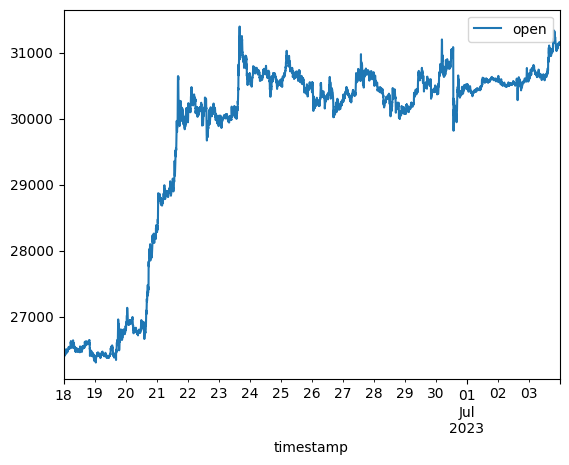

In [16]:
data = data[['open']]

data.plot()

Проделайте следующие шаги:

* Разбейте данные на тренировочную и тестовую часть. В тест отправьте 15% данных

* Извлеките лаговые признаки

* Извлеките агрегированные признаки (средняя стоимость за день, час)

Рекомендуется использовать функцию preprocess_data с вебинара (однако, надо будет незначительно ее поменять, исходя из данных задачи).

Задайте гиперпараметры по умолчанию (в функции preprocess_data, если будете использовать ее):
* `lag_start`=5
* `lag_end`=20
* `test_size`=0.15

In [25]:
data.head()

,open
timestamp,
2023-06-18 00:00:00,26519.10
2023-06-18 00:05:00,26508.01
2023-06-18 00:10:00,26511.30
2023-06-18 00:15:00,26519.44
2023-06-18 00:20:00,26513.33


In [24]:
data.iloc[:150]

,open
timestamp,
2023-06-18 00:00:00,26519.10
2023-06-18 00:05:00,26508.01
2023-06-18 00:10:00,26511.30
2023-06-18 00:15:00,26519.44
2023-06-18 00:20:00,26513.33
...,...
2023-06-18 12:05:00,26500.81
2023-06-18 12:10:00,26512.65
2023-06-18 12:15:00,26505.97


In [32]:
data.index.weekday

Index([6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       ...
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype='int32', name='timestamp', length=4608)

In [28]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [36]:
round((0.85) * data.shape[0], 0)

3917.0

In [41]:
def preprocess_data(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data['open'].shift(i)

    
    date_cut = int(round((1 - test_size) * data.shape[0], 0))
    data = data.dropna()

    data["day_of_week"] = data.index.weekday

    # считаем средние только по тренировочной части, чтобы избежать лика (data leak)
    data["day_average"] = list(map(code_mean(data.iloc[: date_cut], "day_of_week", "open").get, data.day_of_week))

    # выкидываем закодированные средними признаки
    data.drop(["day_of_week"], axis=1, inplace=True)

    data["hour"] = data.index.hour

    # считаем средние только по тренировочной части, чтобы избежать лика (data leak)
    data["hour_average"] = list(map(code_mean(data.iloc[: date_cut], "hour", "open").get, data.hour))

    # выкидываем закодированные средними признаки
    data.drop(["hour"], axis=1, inplace=True)


    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.iloc[:date_cut].drop(["open"], axis=1)
    y_train = data.iloc[:date_cut]["open"]
    X_test = data.iloc[date_cut:].drop(["open"], axis=1)
    y_test = data.iloc[date_cut:]["open"]

    return X_train, X_test, y_train, y_test

Обучите линейную регрессию с гиперпараметрами по умолчанию на тренировочных данных и вычислите ошибку MAE на тестовых данных.

Чему она получилась равна? (Ответ округлите до целого числа).

Также нарисуйте график правильного ответа и прогноза на тесте.

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
X_train, X_test, y_train, y_test = preprocess_data(data)

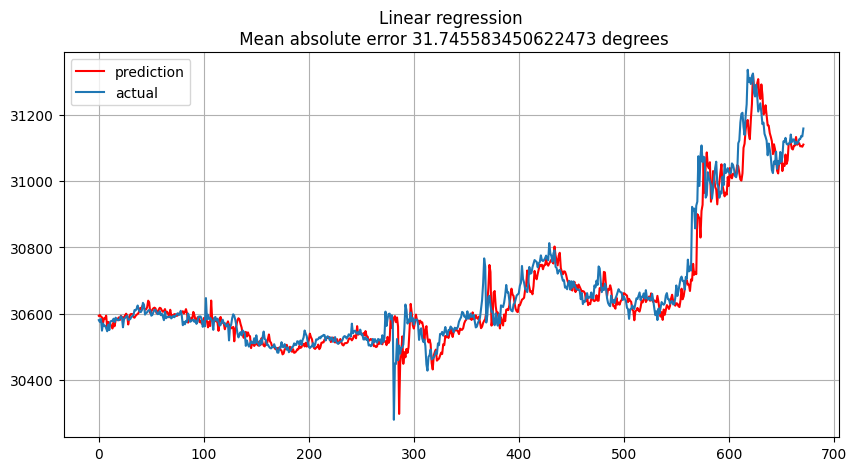

In [46]:
model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds, y_test)} degrees");

Попробуйте подобрать гиперпараметры `lag_start`, `lag_end`, а также придумать новые полезные агрегрированные признаки для улучшения качества прогноза.

Пропорции разбиения (в тесте 15% данных) не трогайте. Ошибку MAE все так же считайте на тесте.

In [ ]:
# your code here